In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Autoreload libraries
%load_ext autoreload
%autoreload 2

## Create vortex street simulation

I am using this code to generate training data for the class

This demo is taken from the instructions [here](https://pylbm.readthedocs.io/en/latest/notebooks/07_Von_Karman_vortex_street.html)

Note: I found it easiest to install directly from setup.py, and to create a virtualenvironment matching the authors' exact requirements file.

Alternatively, one can downgrade numpy to get the current version working

```bash
pip install "numpy<1.24.0"
```



[Link](https://utexas.box.com/v/vortexstreet) to simulation output data hosted on Box.

Reynolds number:  1.800e+03
Bulk viscosity :  1.000e-03
Shear viscosity:  2.778e-06
relaxation parameters: [0.0, 0.0, 0.0, 1.1312217194570136, 1.1312217194570136, 1.9957424161788186, 1.9957424161788186, 1.9957424161788186, 1.9957424161788186]


t = 0.00, 0.00%
t = 0.39, 0.02%
t = 0.78, 0.04%
t = 1.17, 0.06%
t = 1.56, 0.08%
t = 1.95, 0.10%
t = 2.34, 0.12%
t = 2.73, 0.15%
t = 3.12, 0.17%
t = 3.52, 0.19%
t = 3.91, 0.21%
t = 4.30, 0.23%
t = 4.69, 0.25%
t = 5.08, 0.27%
t = 5.47, 0.29%
t = 5.86, 0.31%
t = 6.25, 0.33%
t = 6.64, 0.35%
t = 7.03, 0.38%
t = 7.42, 0.40%
t = 7.81, 0.42%
t = 8.20, 0.44%
t = 8.59, 0.46%
t = 8.98, 0.48%
t = 9.38, 0.50%
t = 9.77, 0.52%
t = 10.16, 0.54%
t = 10.55, 0.56%
t = 10.94, 0.58%
t = 11.33, 0.60%
t = 11.72, 0.62%
t = 12.11, 0.65%
t = 12.50, 0.67%
t = 12.89, 0.69%
t = 13.28, 0.71%
t = 13.67, 0.73%
t = 14.06, 0.75%
t = 14.45, 0.77%
t = 14.84, 0.79%
t = 15.23, 0.81%
t = 15.62, 0.83%
t = 16.02, 0.85%
t = 16.41, 0.88%
t = 16.80, 0.90%
t = 17.19, 0.92%
t = 17.58, 0.94%
t = 17.97, 0.96%
t = 18.36, 0.98%
t = 18.75, 1.00%
t = 19.14, 1.02%
t = 19.53, 1.04%
t = 19.92, 1.06%
t = 20.31, 1.08%
t = 20.70, 1.10%
t = 21.09, 1.12%
t = 21.48, 1.15%
t = 21.88, 1.17%
t = 22.27, 1.19%
t = 22.66, 1.21%
t = 23.05, 1.23%
t = 23

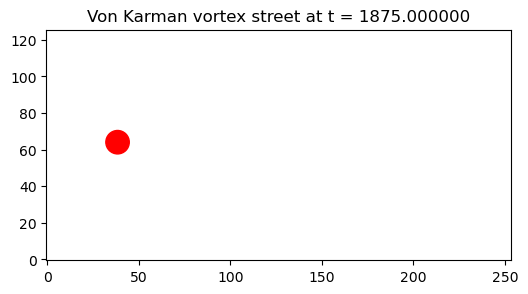

In [17]:

import sympy as sp
import pylbm

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc_in(f, m, x, y):
    m[qx] = rhoo * v0

def eulerian_fields(sol):
    ux = sol.m[qx] / sol.m[rho]
    uy = sol.m[qy] / sol.m[rho]
    w = np.abs(uy[2:,1:-1] - uy[0:-2,1:-1] - ux[1:-1,2:] + ux[1:-1,0:-2])/(2*sol.domain.dx)
    return -ux, uy, w

# parameters
rayon = 0.05
# Re = 500 * 12
# Re = 600
Re = 1800
dx = 1./64/2   # spatial step
la = 1.      # velocity of the scheme
Tf = 75*5*5      # final time of the simulation
v0 = la/20   # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-3   # bulk viscosity
eta = rhoo*v0*2*rayon/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax = 0., 2., 0., 1.
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0 / (0.5 + eta*  dummy)
s_q = s_eta
s_es = s_mu
s  = [0., 0., 0., s_mu, s_es, s_q, s_q, s_eta, s_eta]
dummy = 1. / (LA**2 * rhoo)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

print("Reynolds number: {0:10.3e}".format(Re))
print("Bulk viscosity : {0:10.3e}".format(mu))
print("Shear viscosity: {0:10.3e}".format(eta))
print("relaxation parameters: {0}".format(s))

dico = {
    'box': {'x': [xmin, xmax],
            'y': [ymin, ymax],
            'label': [0, 2, 0, 0]
           },
    'elements': [pylbm.Circle([.3, 0.5 * (ymin + ymax) + dx], rayon, label=1)],
    'space_step': dx,
    'scheme_velocity': la,
    'parameters': {LA: la},
    'schemes': [
        {
            'velocities': list(range(9)),
            'conserved_moments': [rho, qx, qy],
            'polynomials': [
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters': s,
            'equilibrium': [
                rho, qx, qy,
                -2*rho + 3*q2,
                rho-3*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
        },
    ],
    'init': {rho:rhoo,
             qx:0.,
             qy:0.
    },
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.BouzidiBounceBack}, 'value': bc_in},
        1: {'method': {0: pylbm.bc.BouzidiBounceBack}},
        2: {'method': {0: pylbm.bc.NeumannX}},
    },
    'generator': 'cython',
}

# sol = pylbm.Simulation(dico)
# while sol.t < Tf:
#     sol.one_time_step()

sol = pylbm.Simulation(dico)
all_ux, all_uy = list(), list()
ind = 0
while sol.t < Tf:
    ux, uy, w = eulerian_fields(sol)
    if ind % (50) == 0:
        print(f"t = {sol.t:.2f}, {sol.t/(Tf):.2%}")
        all_ux.append(np.copy(ux))
        all_uy.append(np.copy(uy))
    sol.one_time_step()
    ind += 1
all_ux = np.array(all_ux)#[-3000:]
all_uy = np.array(all_uy)#[-3000:]

vfield = np.stack([all_ux, all_uy], axis=-1)
vabs = np.sum(vfield**2, axis=-1)**0.5

viewer = pylbm.viewer.matplotlib_viewer
fig = viewer.Fig()
ax = fig[0]
ux, uy, w = eulerian_fields(sol)
im = ax.image(w.transpose(), clim = [-3., 0])
ax.ellipse([.3/dx, 0.5*(ymin+ymax)/dx], [rayon/dx,rayon/dx], 'r')
ax.title = 'Von Karman vortex street at t = {0:f}'.format(sol.t)
fig.show()

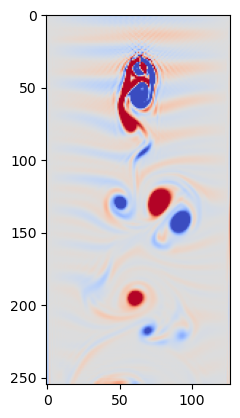

In [18]:
vfield[200:].dump(f"/Users/william/program_repos/cphy/resources/von_karman_street/vortex_street_velocities_Re_{Re}_{vfield.shape[0]}timepoints.npz")
vort_field = np.diff(vfield[..., 0], axis=2)[:, :-1, ...] + np.diff(vfield[..., 1], axis=1)[:, :, :-1]
vscale = np.max(np.abs(vort_field)) * 0.1
plt.imshow(vort_field[-1], vmin=-vscale, vmax=vscale, cmap="coolwarm")


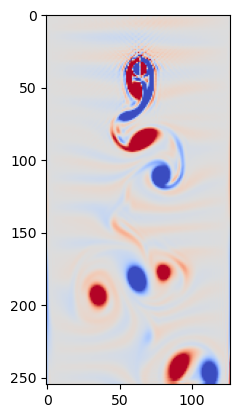

# Lid driven cavity flow

In [ ]:

import sympy as sp
import pylbm

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc(f, m, x, y):
    m[qx] = rhoo * vup

def eulerian_fields(sol):
    ux = sol.m[qx] / sol.m[rho]
    uy = sol.m[qy] / sol.m[rho]
    w = np.abs(uy[2:,1:-1] - uy[0:-2,1:-1] - ux[1:-1,2:] + ux[1:-1,0:-2])/(2*sol.domain.dx)
    return -ux, uy, w

# parameters
Re = 4000
dx = 1./128/4  # spatial step
la = 1.      # velocity of the scheme
Tf = 10*60      # final time of the simulation
vup = la/5   # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-4   # bulk viscosity
eta = rhoo*vup/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax = 0., 1., 0., 1.
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0/(0.5+eta*dummy)
s_q = s_eta
s_es = s_mu
s  = [0.,0.,0.,s_mu,s_es,s_q,s_q,s_eta,s_eta]
dummy = 1./(LA**2*rhoo)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

print("Reynolds number: {0:10.3e}".format(Re))
print("Bulk viscosity : {0:10.3e}".format(mu))
print("Shear viscosity: {0:10.3e}".format(eta))
print("relaxation parameters: {0}".format(s))

dico = {
    'box': {'x': [xmin, xmax],
            'y': [ymin, ymax],
            'label': [0, 0, 0, 1]
           },
    'space_step': dx,
    'scheme_velocity': la,
    'parameters': {LA: la},
    'schemes': [
        {
            'velocities': list(range(9)),
            'conserved_moments': [rho, qx, qy],
            'polynomials': [
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                0.5*(9*(X**2+Y**2)**2-21*(X**2+Y**2)+8),
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters': s,
            'equilibrium': [
                rho, qx, qy,
                -2*rho + 3*q2,
                rho-3*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
        },
    ],
    'init': {rho: rhoo,
             qx:0.,
             qy:0.
    },
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.BouzidiBounceBack}},
        1: {'method': {0: pylbm.bc.BouzidiBounceBack}, 'value': bc}
    },
    'generator': 'cython',
}

# sol = pylbm.Simulation(dico)
# while sol.t < Tf:
#     sol.one_time_step()

sol = pylbm.Simulation(dico)
all_ux, all_uy = list(), list()
ind = 0
while sol.t < Tf:
    ux, uy, w = eulerian_fields(sol)
    if ind % (50) == 0:
        all_ux.append(np.copy(ux))
        all_uy.append(np.copy(uy))
    sol.one_time_step()
    ind += 1
all_ux = np.array(all_ux)#[-3000:]
all_uy = np.array(all_uy)#[-3000:]

vfield = np.stack([all_ux, all_uy], axis=-1)
vabs = np.sum(vfield**2, axis=-1)**0.5



Reynolds number:  4.000e+03
Bulk viscosity :  1.000e-04
Shear viscosity:  5.000e-05
relaxation parameters: [0.0, 0.0, 0.0, 1.5299877600979193, 1.5299877600979193, 1.7337031900138697, 1.7337031900138697, 1.7337031900138697, 1.7337031900138697]


KeyboardInterrupt: 

In [38]:
all_ux = np.array(all_ux)#[-3000:]
all_uy = np.array(all_uy)#[-3000:]

vfield = np.stack([all_ux, all_uy], axis=-1)
vabs = np.sum(vfield**2, axis=-1)**0.5

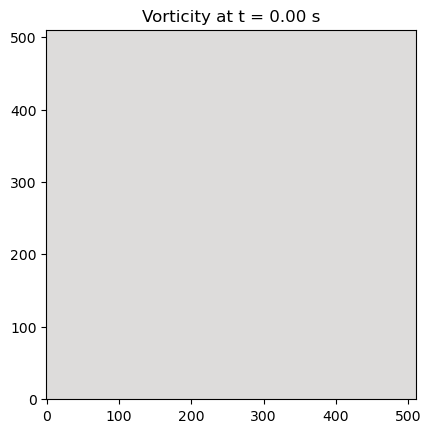

In [40]:
# vort_field = np.diff(vfield[..., 0], axis=2)[:, :-1, ...] + np.diff(vfield[..., 1], axis=1)[:, :, :-1]
# vscale = np.max(np.abs(vort_field)) * 0.1
# plt.imshow(vort_field[-1], vmin=-vscale, vmax=vscale, cmap="coolwarm", origin="lower")

## make an HTML video from vort_field
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate(i):
    ax.clear()
    ax.imshow(vort_field[i], vmin=-vscale, vmax=vscale, cmap="coolwarm", origin="lower")
    ax.set_title(f"Vorticity at t = {i*dt:.2f} s")
    return ax

fig, ax = plt.subplots()
dt = 0.1
ani = FuncAnimation(fig, animate, frames=len(vort_field), interval=100)
ani.save('vorticity_animation.mp4', writer='ffmpeg', fps=30)

# 3D Lid driven cavity flow



In [57]:
X, Y, Z, LA = sp.symbols('X, Y, Z, LA')
rho, qx, qy, qz = sp.symbols('rho, qx, qy, qz')

def bc(f, m, x, y, z):
    m[qx] = rhoo * vup

def eulerian_fields(sol):
    ux = sol.m[qx] / sol.m[rho]
    uy = sol.m[qy] / sol.m[rho]
    uz = sol.m[qz] / sol.m[rho]
    w = np.abs(uy[2:,1:-1] - uy[0:-2,1:-1] - ux[1:-1,2:] + ux[1:-1,0:-2])/(2*sol.domain.dx)
    return -ux, uy, uz, w

def plot(sol):
    plt.clf()
    pas = 4
    nz = int(sol.domain.shape_in[1] / 2) + 1
    y, x = np.meshgrid(sol.domain.y[::pas], sol.domain.x[::pas])
    u = sol.m[qx][::pas,nz,::pas] / sol.m[rho][::pas,nz,::pas]
    v = sol.m[qz][::pas,nz,::pas] / sol.m[rho][::pas,nz,::pas]
    nv = np.sqrt(u**2+v**2)
    normu = nv.max()
    u = u / (nv+1e-5)
    v = v / (nv+1e-5)
    plt.quiver(x, y, u, v, nv, pivot='mid')
    plt.title('Solution at t={0:9.3f}'.format(sol.t))
    plt.show()

# parameters
Re = 10000
dx = 1./64/4   # spatial step
la = 1.      # velocity of the scheme
Tf = 3*5      # final time of the simulation
vup = la/10  # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
eta = rhoo*vup/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax, zmin, zmax = 0., 1., 0., 1., 0., 1.
dummy = 3.0/(la*rhoo*dx)

s1 = 1.6
s2 = 1.2
s4 = 1.6
s9 = 1./(.5+dummy*eta)
s11 = s9
s14 = 1.2
s  = [0, s1, s2, 0, s4, 0, s4, 0, s4, s9, s9, s11, s11, s11, s14]

r = X**2+Y**2+Z**2

print("Reynolds number: {0:10.3e}".format(Re))
print("Shear viscosity: {0:10.3e}".format(eta))

dico = {
    'box':{
        'x': [xmin, xmax],
        'y': [ymin, ymax],
        'z': [zmin, zmax],
        'label': [0, 0, 0, 0, 0, 1]
    },
    'space_step': dx,
    'scheme_velocity': la,
    'parameters': {LA: la},
    'schemes': [
        {
            'velocities': list(range(7)) + list(range(19,27)),
            'conserved_moments': [rho, qx, qy, qz],
            'polynomials': [
                1,
                r - 2, .5*(15*r**2-55*r+32),
                X, .5*(5*r-13)*X,
                Y, .5*(5*r-13)*Y,
                Z, .5*(5*r-13)*Z,
                3*X**2-r, Y**2-Z**2,
                X*Y, Y*Z, Z*X,
                X*Y*Z
            ],
            'relaxation_parameters': s,
            'equilibrium': [
                rho,
                -rho + qx**2 + qy**2 + qz**2,
                -rho,
                qx,
                -7./3*qx,
                qy,
                -7./3*qy,
                qz,
                -7./3*qz,
                1./3*(2*qx**2-(qy**2+qz**2)),
                qy**2-qz**2,
                qx*qy,
                qy*qz,
                qz*qx,
                0
            ],
        },
    ],
    'init': {rho: rhoo,
             qx: 0.,
             qy: 0.,
             qz: 0.
    },
    'boundary_conditions':{
        0: {'method': {0: pylbm.bc.BouzidiBounceBack}},
        1: {'method': {0: pylbm.bc.BouzidiBounceBack}, 'value': bc}
    },
    'generator': 'cython',
}

sol = pylbm.Simulation(dico)
all_ux, all_uy, all_uz = list(), list(), list()
all_w = list()
ind = 0
while sol.t < Tf:
    ux, uy,uz, w = eulerian_fields(sol)
    if ind % (50) == 0:
        print(f"t = {sol.t:.2f}, {sol.t/(Tf):.2%}")
        all_ux.append(np.copy(ux))
        all_uy.append(np.copy(uy))
        all_uz.append(np.copy(uz))
        all_w.append(np.copy(w))
    sol.one_time_step()
    ind += 1
all_ux = np.array(all_ux)#[-3000:]
all_uy = np.array(all_uy)#[-3000:]
all_uz = np.array(all_uz)#[-3000:]

vfield = np.stack([all_ux, all_uy, all_uz], axis=-1)
vabs = np.sum(vfield**2, axis=-1)**0.5

Reynolds number:  1.000e+04
Shear viscosity:  1.000e-05
t = 0.00, 0.00%
t = 0.20, 1.30%
t = 0.39, 2.60%
t = 0.59, 3.91%
t = 0.78, 5.21%
t = 0.98, 6.51%
t = 1.17, 7.81%
t = 1.37, 9.11%
t = 1.56, 10.42%
t = 1.76, 11.72%
t = 1.95, 13.02%
t = 2.15, 14.32%
t = 2.34, 15.62%
t = 2.54, 16.93%
t = 2.73, 18.23%
t = 2.93, 19.53%
t = 3.12, 20.83%
t = 3.32, 22.14%
t = 3.52, 23.44%
t = 3.71, 24.74%


/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_29221/3117209437.py:8: RuntimeWarning: divide by zero encountered in divide
  ux = sol.m[qx] / sol.m[rho]
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_29221/3117209437.py:8: RuntimeWarning: invalid value encountered in divide
  ux = sol.m[qx] / sol.m[rho]
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_29221/3117209437.py:9: RuntimeWarning: divide by zero encountered in divide
  uy = sol.m[qy] / sol.m[rho]
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_29221/3117209437.py:9: RuntimeWarning: invalid value encountered in divide
  uy = sol.m[qy] / sol.m[rho]
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_29221/3117209437.py:10: RuntimeWarning: divide by zero encountered in divide
  uz = sol.m[qz] / sol.m[rho]
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_29221/3117209437.py:10: RuntimeWarning: invalid value encountered in divide
  uz = sol.m[qz] / sol.m[rho]
/var/folder

t = 3.91, 26.04%
t = 4.10, 27.34%
t = 4.30, 28.65%
t = 4.49, 29.95%
t = 4.69, 31.25%
t = 4.88, 32.55%
t = 5.08, 33.85%


KeyboardInterrupt: 

In [54]:
print(f"t = {sol.t:.2f}, {sol.t/(Tf):.2%}")

vfield = np.stack([all_ux, all_uy, all_uz], axis=-1)
vabs = np.sum(vfield**2, axis=-1)**0.5

t = 1.77, 11.82%


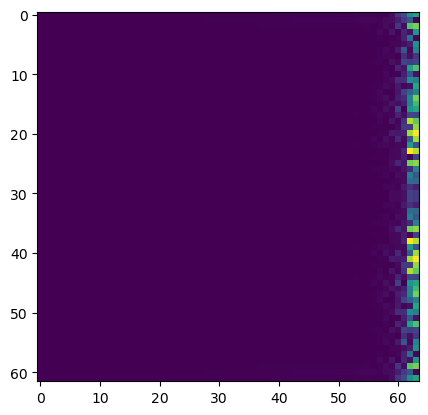

In [49]:
plt.imshow(w[32])

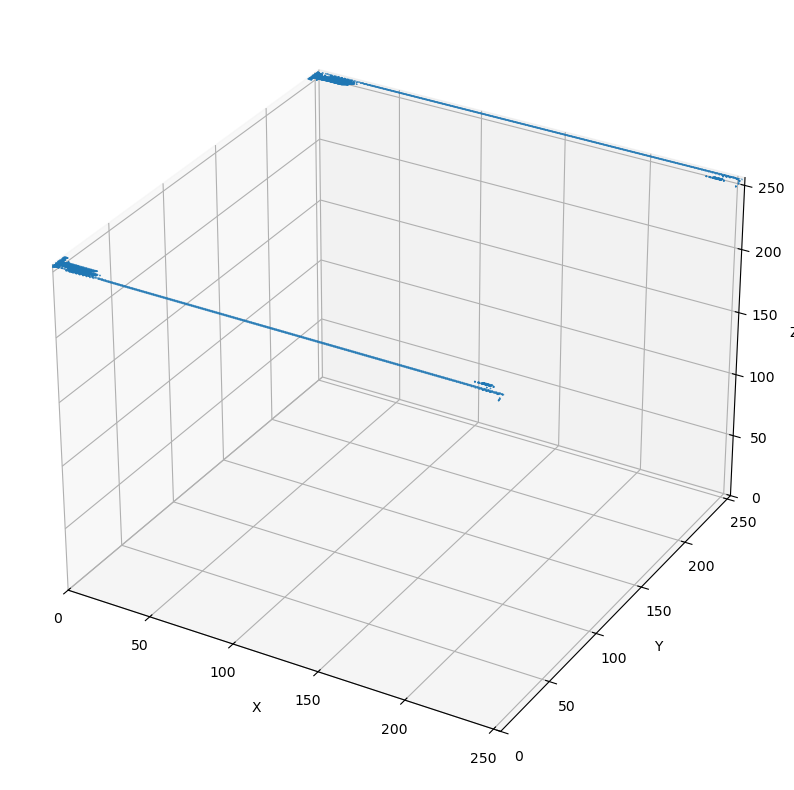

In [62]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes



# Replace this with your actual vorticity field; here we use a dummy array for illustration.
vorticity = np.log(all_w[12].copy())

# Define an isovalue; adjust this threshold depending on your data’s distribution.
iso_value = 0.5 * np.max(vorticity)

verts, faces, normals, values = marching_cubes(vorticity, level=iso_value)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the translucent isosurface
mesh = Poly3DCollection(verts[faces], alpha=0.5)
ax.add_collection3d(mesh)      # Attach mesh to the Axes so that its axes attribute is set.
mesh.set_edgecolor('face')     # Now it can access ax without error.

# Set plot limits and labels.
ax.set_xlim(0, vorticity.shape[0])
ax.set_ylim(0, vorticity.shape[1])
ax.set_zlim(0, vorticity.shape[2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [4]:
vfield.shape

(4800, 256, 128, 2)

In [152]:
#vfield = np.load("./von_karman_street/vortex_street_velocities_Re_300_largefile.npz", allow_pickle=True)
# vfield = np.load("./von_karman_street/vortex_street_velocities_Re_600_largefile.npz", allow_pickle=True)
#vfield = np.load("./von_karman_street/vortex_street_velocities_Re_900_largefile.npz", allow_pickle=True)
vfield = np.load("../resources/von_karman_street/vortex_street_velocities_Re_1200_largefile.npz", allow_pickle=True)



In [136]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets



# vscale = np.max(np.abs(vabs))
# def plotter(i):
#     # plt.close()
#     fig = plt.figure(figsize=(10, 10))
#     plt.imshow(vabs[i], vmin=-vscale, vmax=vscale, cmap="coolwarm")
#     plt.show()


vort_field = np.abs(
    np.diff(vfield, axis=1)[..., :-1, 1] 
    + np.diff(vfield, axis=2)[:, :-1, :, 0] 
)

vscale = np.max(np.abs(vort_field)) * 0.1
def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(vort_field[i], vmin=-vscale, vmax=vscale, cmap="coolwarm")
    plt.show()



interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(vort_field) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=2999), Output()), …

<function __main__.plotter(i)>

/Users/williamgilpin/miniconda3/envs/pylbm_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


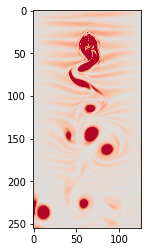

In [138]:

from scipy.signal import resample

plt.imshow(vort_field[-100], vmin=-vscale, vmax=vscale, cmap="coolwarm")
# plt.show()

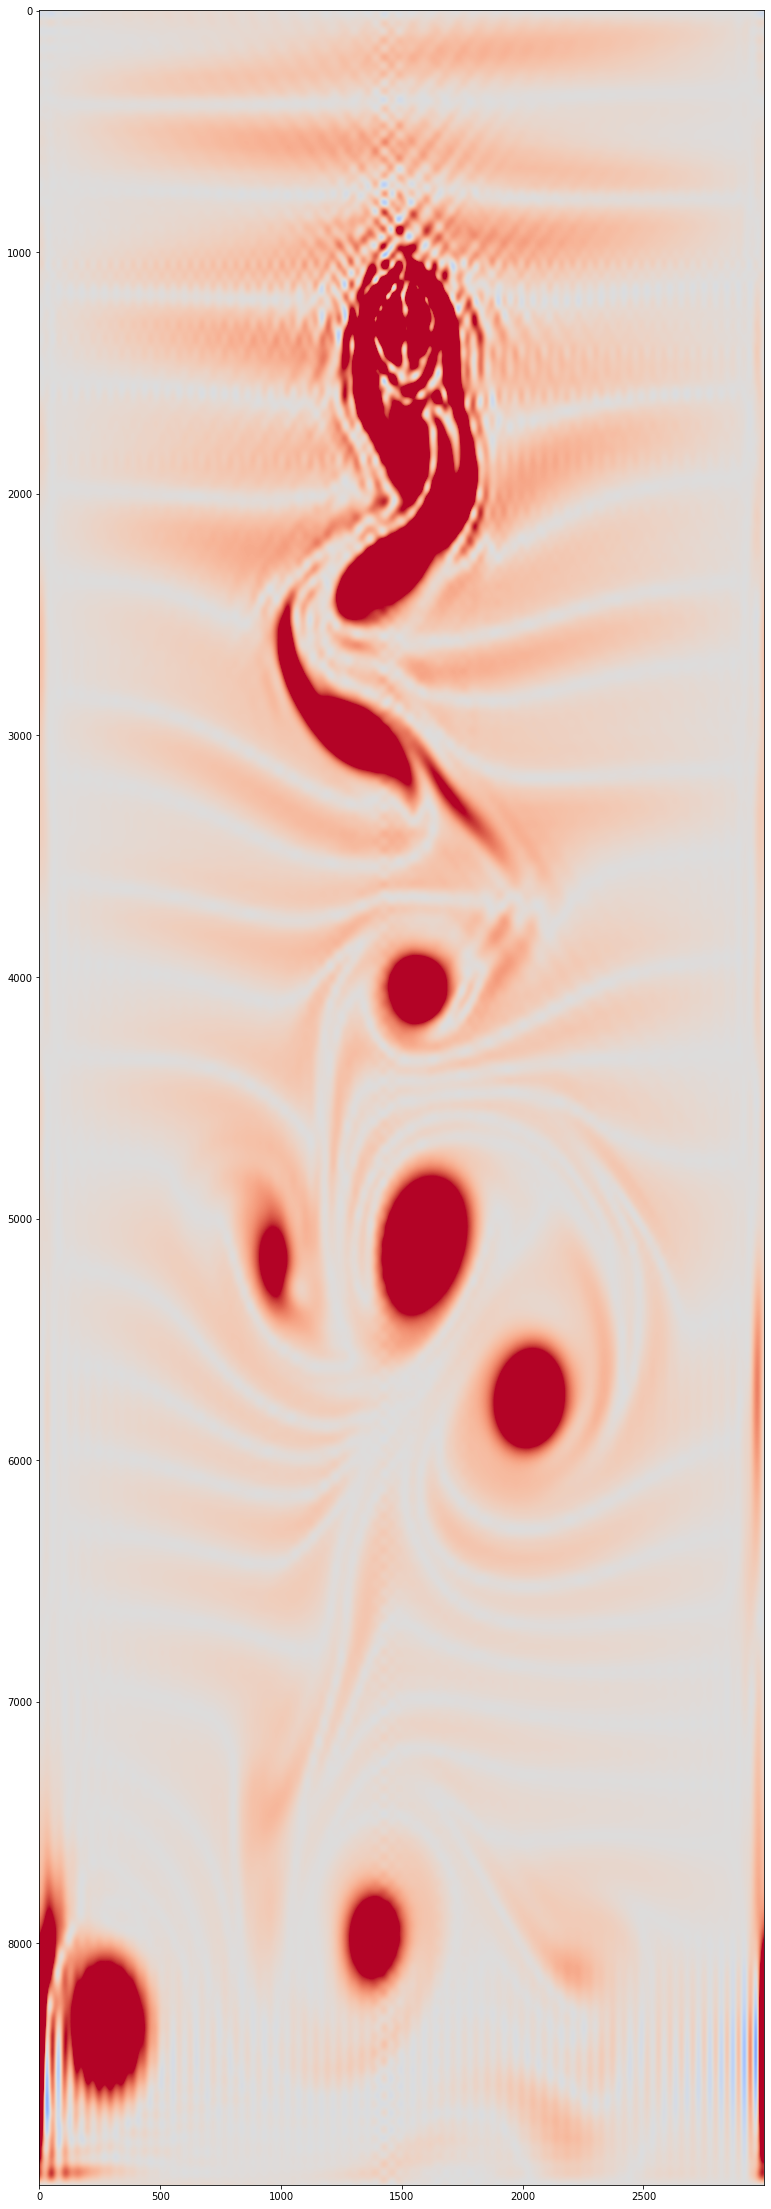

In [151]:
plt.figure(figsize=(40, 40))
plt.imshow(
    resample(resample(vort_field[-100], 9000, axis=0), 3000, axis=1),
     vmin=-vscale, vmax=vscale, cmap="coolwarm"
)

In [43]:
import numpy as np
from scipy.signal import fftconvolve

def piv(frame1, frame2, window_size=32, overlap=0.5, correlation_method='linear'):
    """
    Computes the displacement field between two frames using PIV.

    Parameters:
    -----------
    frame1 : numpy.ndarray
        First frame of the image sequence.
    frame2 : numpy.ndarray
        Second frame of the image sequence.
    window_size : int, optional
        Size of the interrogation window. Must be a power of 2.
    overlap : float, optional
        Fractional overlap between neighboring interrogation windows.
    correlation_method : str, optional
        Correlation method used to compute the cross-correlation between the two image patches.
        Allowed values are 'linear', 'square', and 'cubic'.

    Returns:
    --------
    displacement : numpy.ndarray
        Array of shape (2, M, N) representing the x and y displacements at each pixel of the image.
    """

    # Check that the window size is a power of 2
    assert (window_size & (window_size - 1)) == 0, "Window size must be a power of 2"

    # Compute the stride and overlap between adjacent windows
    stride = int(window_size * (1 - overlap))
    overlap_pixels = int(window_size * overlap)

    # Compute the displacement field
    height, width = frame1.shape
    displacement = np.zeros((2, height, width), dtype=np.float32)

    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            # Extract the two image patches
            patch1 = frame1[y:y + window_size, x:x + window_size]
            patch2 = frame2[y:y + window_size, x:x + window_size]

            # Compute the cross-correlation between the two patches
            corr = fftconvolve(patch1, patch2[::-1, ::-1], mode='same')
            max_idx = np.unravel_index(np.argmax(corr), corr.shape)

            # Compute the displacement between the two patches
            dy, dx = np.array(max_idx) - window_size // 2

            # Store the displacement at the center of the window
            cx, cy = x + window_size // 2, y + window_size // 2
            displacement[0, cy, cx] = dx
            displacement[1, cy, cx] = dy

    # Fill in the overlap regions
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            cx, cy = x + window_size // 2, y + window_size // 2

            # Fill in the x overlap
            if x > 0:
                displacement[0, cy, x:x + overlap_pixels] = displacement[0, cy, cx]
            if x + window_size < width:
                displacement[0, cy, x + window_size - overlap_pixels:x + window_size] = displacement[0, cy, cx]

            # Fill in the y overlap
            if y > 0:
                displacement[1, y:y + overlap_pixels, cx] = displacement[1, cy, cx]
            if y + window_size < height:
                displacement[1, y + window_size - overlap_pixels:y + window_size, cx] = displacement[1, cy, cx]


                

    return displacement

In [44]:
disps = piv(vort_field[-100], vort_field[-600])

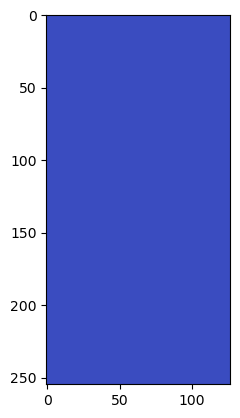

In [45]:
plt.imshow(disps[0]**2, cmap="coolwarm")